# Library

In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import random
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

# 한글 폰트 설정
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

# warning 무시
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameter Setting

In [ ]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':41
}

# Fixed RandomSEED

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# Data Load

In [ ]:
def data_load(base_path, label):
  data = pd.read_csv(f'{base_path}/{label}.csv')
  return data

In [ ]:
base_path = '/content/drive/My Drive/sentence'

train = data_load(base_path, 'train')
test = data_load(base_path, 'test')

In [ ]:
train.shape, test.shape

((16541, 7), (7090, 2))

In [ ]:
display(train.sample(5))
display(test.sample(5))

,ID,문장,유형,극성,시제,확실성,label
11726,TRAIN_11726,"사회참여와 봉사영역은 개인적으로 다양한 연령층과 함께 봉사 및 기부활동 참여, 사회...",사실형,긍정,현재,확실,사실형-긍정-현재-확실
9458,TRAIN_09458,현재는 안드로이드어서 사용이 가능하지만 추후 PC로도 업데이트될 예정이다.,사실형,긍정,미래,불확실,사실형-긍정-미래-불확실
1446,TRAIN_01446,신병주 건국대 교수는 이런 조경을 ＂왕과 권력에 굴하지 않고 직언을 한 원칙과 소신...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
11038,TRAIN_11038,앞서 지난 1월 23일(현지 시간) 장줘얼은 생태계 발전을 위한 ＇채굴세 도입＇을 ...,사실형,긍정,과거,확실,사실형-긍정-과거-확실
10597,TRAIN_10597,10일 만에서 일본 애플 앱스토어 매출 1위를 차지했으며 이후 2019년 7월 ＇호...,사실형,긍정,과거,확실,사실형-긍정-과거-확실


,ID,문장
3359,TEST_3359,"지금은 대표 스타트업으로 성장한 마켓컬리와 프레시지, 제주맥주, 팜에이트, 엔씽, ..."
4127,TEST_4127,통풍은 체내 혈액 내 요산이 원활하게 배출되지 않아 요산염 결정체를 형성하고 관절이...
4036,TEST_4036,"개인적으로 마카다미아는 견과류 중에서도 가장 선호하는 종류이기도 한데, 다소 가격이..."
224,TEST_0224,전 세계에 160여 점밖에 존재하지 않는 고려불화는 청자와 더불어 고려 문화의 독보...
1434,TEST_1434,오페르트는 조선인들에게서 임진왜란 당시 수많은 왜군 탈영병들이 한반도 남쪽으로 달아...


# EDA & Visualization

In [ ]:
train.describe(include='object')

,ID,문장,유형,극성,시제,확실성,label
count,16541,16541,16541,16541,16541,16541,16541
unique,16541,16506,4,3,3,2,64
top,TRAIN_00000,이들 게임은 국내 구글 플레이 매출 톱10 진입이 예상되는 기대작이다.,사실형,긍정,과거,확실,사실형-긍정-과거-확실
freq,1,2,13558,15793,8032,15192,7113


Text(0.5, 1.0, '유형별 count')

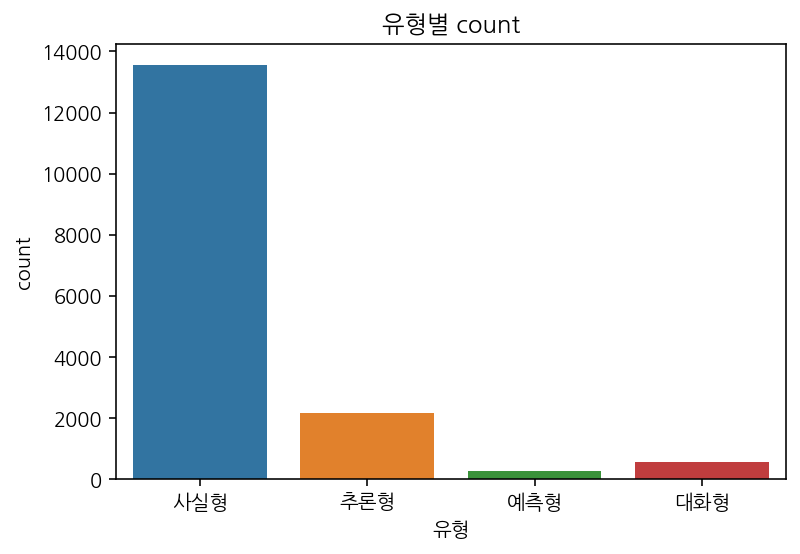

In [ ]:
_=sns.countplot(data=train, x='유형')               
plt.title('유형별 count')

Text(0.5, 1.0, '극성별 count')

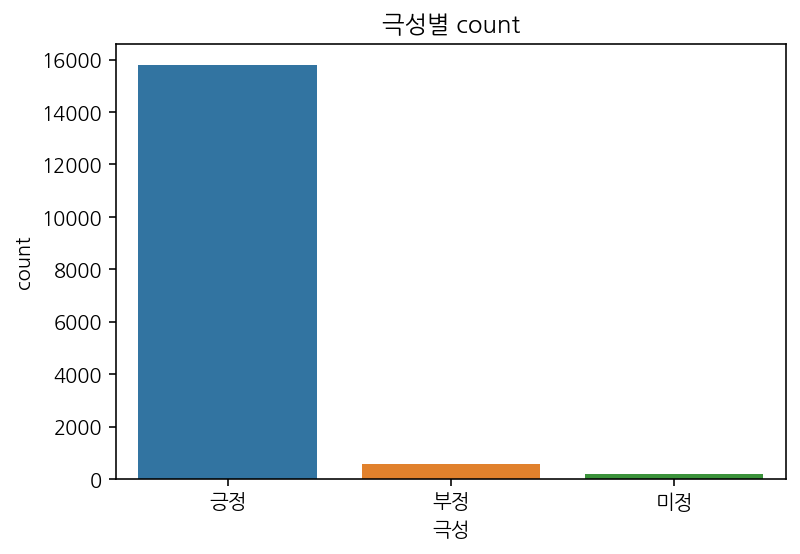

In [ ]:
_=sns.countplot(data=train, x='극성')
plt.title('극성별 count')

Text(0.5, 1.0, '시제 count')

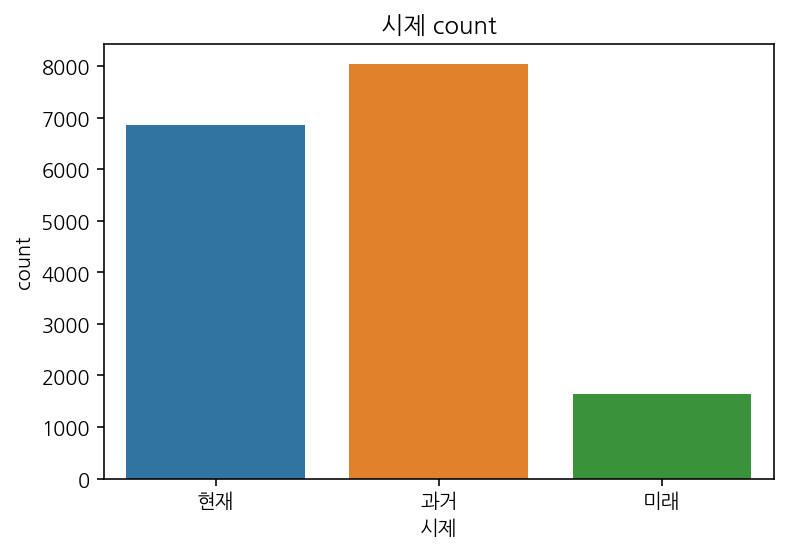

In [ ]:
_=sns.countplot(data=train, x='시제')
plt.title('시제 count')

Text(0.5, 1.0, '확실성 count')

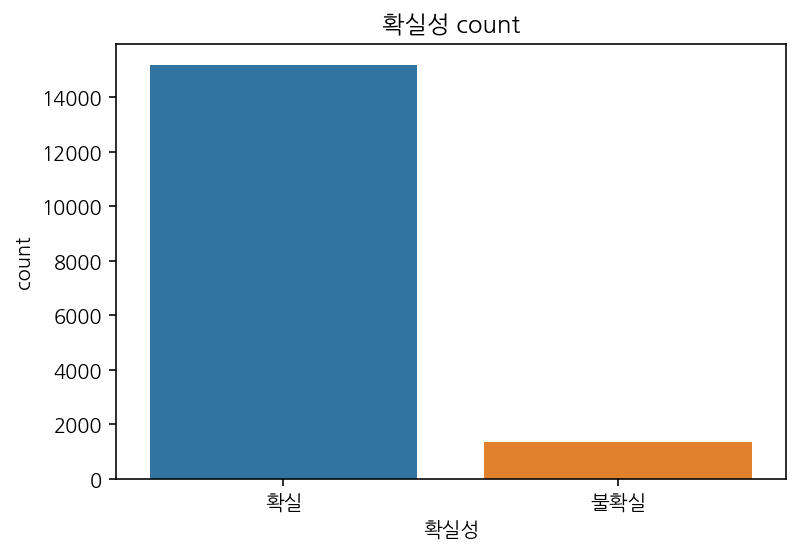

In [ ]:
_=sns.countplot(data=train, x='확실성')
plt.title('확실성 count')

In [ ]:
train['label'].value_counts()

사실형-긍정-과거-확실     7113
사실형-긍정-현재-확실     4743
추론형-긍정-현재-확실     1101
사실형-긍정-미래-확실      649
추론형-긍정-과거-확실      335
                 ... 
대화형-미정-과거-확실        1
예측형-미정-현재-확실        1
예측형-부정-현재-불확실       1
예측형-부정-과거-확실        1
예측형-미정-과거-확실        1
Name: label, Length: 64, dtype: int64

# ID column 삭제

In [ ]:
train = train.drop(columns='ID')
test = test.drop(columns='ID')

# Resampling
- label에 class가 200개 이하인 데이터에서 resampling 과정 진행
- train에 concat

In [ ]:
# label의 class가 100개 이하인 데이터는 48개
train['label'].value_counts()[train['label'].value_counts()<=100].count()

48

In [ ]:
label_index = train['label'].value_counts()[train['label'].value_counts()<=200].index
label_index

Index(['사실형-긍정-현재-불확실', '사실형-부정-과거-확실', '사실형-부정-현재-확실', '추론형-긍정-미래-불확실',
       '사실형-긍정-과거-불확실', '예측형-긍정-미래-불확실', '추론형-긍정-현재-불확실', '대화형-긍정-과거-확실',
       '추론형-부정-현재-확실', '예측형-긍정-미래-확실', '추론형-긍정-과거-불확실', '대화형-긍정-현재-불확실',
       '대화형-미정-현재-불확실', '대화형-긍정-미래-확실', '사실형-미정-미래-확실', '사실형-미정-미래-불확실',
       '대화형-긍정-미래-불확실', '대화형-미정-미래-불확실', '추론형-미정-미래-불확실', '사실형-미정-현재-확실',
       '대화형-긍정-과거-불확실', '추론형-부정-과거-확실', '대화형-부정-현재-확실', '사실형-부정-미래-확실',
       '예측형-긍정-현재-확실', '사실형-부정-현재-불확실', '예측형-미정-미래-불확실', '사실형-부정-과거-불확실',
       '예측형-긍정-과거-확실', '대화형-미정-과거-불확실', '추론형-부정-현재-불확실', '예측형-긍정-현재-불확실',
       '예측형-긍정-과거-불확실', '사실형-미정-현재-불확실', '추론형-부정-미래-확실', '사실형-부정-미래-불확실',
       '추론형-부정-과거-불확실', '추론형-부정-미래-불확실', '대화형-부정-현재-불확실', '대화형-부정-과거-확실',
       '추론형-미정-현재-불확실', '예측형-부정-미래-불확실', '추론형-미정-현재-확실', '추론형-미정-미래-확실',
       '사실형-미정-과거-확실', '예측형-미정-현재-불확실', '대화형-미정-미래-확실', '예측형-미정-미래-확실',
       '추론형-미정-과거-불확실', '대화형-부정-과거-불확실', '대화형-부정-미래-확실', '대화형-미정-과거-확실',
       '예측형-미정-현재-확실', '예측형-부정-현재-불확실', '예측형-부정

In [ ]:
# 각 class에 골고루 resampling 
train_sample = train[train['label'].isin(label_index)]
resampling = train_sample.sample(n=len(train_sample), replace=False)
resampling

,문장,유형,극성,시제,확실성,label
12262,하지만 유머 대신 쫄깃한 첩보 액션물의 바이브를 끝까지 유지했으면 어떨까 하는 아쉬...,사실형,긍정,현재,불확실,사실형-긍정-현재-불확실
14823,"CJ, GS 등 6개 투자사로부터 시리즈A 단계에서 330억원의 투자금도 유치했다.",사실형,긍정,과거,불확실,사실형-긍정-과거-불확실
9412,"임진왜란 때 승병을 이끌며 공을 세웠던 서산대사가 문집을 냈는데, 솜씨는 별로였던 ...",추론형,긍정,과거,불확실,추론형-긍정-과거-불확실
16017,과학자들은 사망한 소년이 유목민이라는 점을 고려했을 때 따뜻한 날씨에 동토층이 녹으...,대화형,긍정,과거,확실,대화형-긍정-과거-확실
9154,반도체 컨설팅업체 테크인사이트의 칩 이코노미스트인 댄 허치슨은 ＂하이 NA EUV는...,대화형,긍정,과거,확실,대화형-긍정-과거-확실
...,...,...,...,...,...,...
4912,장애인주차구역에서 차가 나올 때는 장애인이 꼭 탑승하지 않아도 된다.,사실형,부정,현재,확실,사실형-부정-현재-확실
8595,대신증권은 투자자 피해가 거의 없었다.,사실형,부정,과거,확실,사실형-부정-과거-확실
15728,향후 개발이 완료되면 상주인구만 20만명을 넘어설 것으로 예상된다.,예측형,긍정,미래,불확실,예측형-긍정-미래-불확실
9013,올해 새로운 디바이스와 소프트웨어 출시를 준비하고 있는 구글만 하더라도 그런 신제품...,대화형,긍정,과거,확실,대화형-긍정-과거-확실


In [ ]:
resampling['label'].value_counts()

사실형-긍정-현재-불확실    200
사실형-부정-과거-확실     183
사실형-부정-현재-확실     174
추론형-긍정-미래-불확실    167
사실형-긍정-과거-불확실    144
예측형-긍정-미래-불확실    141
추론형-긍정-현재-불확실    130
대화형-긍정-과거-확실     120
추론형-부정-현재-확실      93
예측형-긍정-미래-확실      57
추론형-긍정-과거-불확실     49
대화형-긍정-현재-불확실     44
대화형-미정-현재-불확실     29
사실형-미정-미래-확실      26
대화형-긍정-미래-확실      26
대화형-미정-미래-불확실     22
대화형-긍정-미래-불확실     22
사실형-미정-미래-불확실     22
추론형-미정-미래-불확실     20
사실형-미정-현재-확실      18
대화형-긍정-과거-불확실     16
추론형-부정-과거-확실      16
대화형-부정-현재-확실      14
사실형-부정-미래-확실      14
예측형-긍정-현재-확실      13
사실형-부정-현재-불확실     11
예측형-미정-미래-불확실     10
사실형-부정-과거-불확실     10
대화형-미정-과거-불확실     10
예측형-긍정-과거-확실      10
추론형-부정-현재-불확실      9
예측형-긍정-과거-불확실      8
예측형-긍정-현재-불확실      8
추론형-부정-미래-확실       7
사실형-미정-현재-불확실      7
추론형-부정-과거-불확실      6
사실형-부정-미래-불확실      6
대화형-부정-과거-확실       5
대화형-부정-현재-불확실      5
추론형-부정-미래-불확실      5
추론형-미정-현재-불확실      4
예측형-부정-미래-불확실      3
추론형-미정-현재-확실       2
예측형-미정-현재-불확실      2
추론형-미정-미래-확실       2
사실형-미정-과거-확실       2
대화형-미정-미래-확실       2
추론형-미정-과거-불확실

In [ ]:
# concat
train_resample = pd.concat([train, resampling], axis=0)
train_resample['label'].value_counts()

사실형-긍정-과거-확실     7113
사실형-긍정-현재-확실     4743
추론형-긍정-현재-확실     1101
사실형-긍정-미래-확실      649
사실형-긍정-현재-불확실     400
                 ... 
대화형-미정-과거-확실        2
예측형-미정-현재-확실        2
예측형-부정-현재-불확실       2
예측형-부정-과거-확실        2
예측형-미정-과거-확실        2
Name: label, Length: 64, dtype: int64

# Train/Test Split

In [ ]:
X_train, X_val, _, _ = train_test_split(train, train['label'], test_size=0.2, random_state=CFG['SEED'])
X_train.shape, X_val.shape

((13232, 6), (3309, 6))

# Preprocessing
- '유형', '극세', '시제', '확실성' columns 각각 Encoding
- TfidfVectorizer를 이용하여 벡터화

In [ ]:
vectorizer = TfidfVectorizer(min_df = 4, analyzer = 'word', ngram_range=(1,2))
vectorizer.fit(np.array(X_train["문장"]))

train_vec = vectorizer.transform(X_train["문장"])
val_vec = vectorizer.transform(X_val["문장"])
test_vec = vectorizer.transform(test["문장"])

print(train_vec.shape, val_vec.shape, test_vec.shape)

(13232, 9351) (3309, 9351) (7090, 9351)


In [ ]:
type_le = preprocessing.LabelEncoder()
X_train["유형"] = type_le.fit_transform(X_train["유형"].values)
X_val["유형"] = type_le.transform(X_val["유형"].values)

polarity_le = preprocessing.LabelEncoder()
X_train["극성"] = polarity_le.fit_transform(X_train["극성"].values)
X_val["극성"] = polarity_le.transform(X_val["극성"].values)

tense_le = preprocessing.LabelEncoder()
X_train["시제"] = tense_le.fit_transform(X_train["시제"].values)
X_val["시제"] = tense_le.transform(X_val["시제"].values)

certainty_le = preprocessing.LabelEncoder()
X_train["확실성"] = certainty_le.fit_transform(X_train["확실성"].values)
X_val["확실성"] = certainty_le.transform(X_val["확실성"].values)

In [ ]:
train_type = X_train["유형"].values # sentence type
train_polarity = X_train["극성"].values # sentence polarity
train_tense = X_train["시제"].values # sentence tense
train_certainty = X_train["확실성"].values # sentence certainty

train_labels = {
    'type' : train_type,
    'polarity' : train_polarity,
    'tense' : train_tense,
    'certainty' : train_certainty
}

In [ ]:
train_labels

{'type': array([1, 1, 1, ..., 0, 1, 1]),
 'polarity': array([0, 0, 0, ..., 0, 0, 0]),
 'tense': array([0, 0, 2, ..., 2, 0, 2]),
 'certainty': array([1, 1, 1, ..., 1, 1, 1])}

In [ ]:
val_type = X_val["유형"].values # sentence type
val_polarity = X_val["극성"].values # sentence polarity
val_tense = X_val["시제"].values # sentence tense
val_certainty = X_val["확실성"].values # sentence certainty

val_labels = {
    'type' : val_type,
    'polarity' : val_polarity,
    'tense' : val_tense,
    'certainty' : val_certainty
}

In [ ]:
val_labels

{'type': array([1, 1, 1, ..., 1, 1, 1]),
 'polarity': array([0, 0, 0, ..., 0, 0, 0]),
 'tense': array([0, 0, 2, ..., 0, 0, 0]),
 'certainty': array([1, 1, 1, ..., 1, 1, 1])}

# CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, st_vec, st_labels):
        self.st_vec = st_vec
        self.st_labels = st_labels

    def __getitem__(self, index):
        st_vector = torch.FloatTensor(self.st_vec[index].toarray()).squeeze(0)
        if self.st_labels is not None:
            st_type = self.st_labels['type'][index]
            st_polarity = self.st_labels['polarity'][index]
            st_tense = self.st_labels['tense'][index]
            st_certainty = self.st_labels['certainty'][index]
            return st_vector, st_type, st_polarity, st_tense, st_certainty
        else:
            return st_vector

    def __len__(self):
        return len(self.st_vec.toarray())

In [ ]:
train_dataset = CustomDataset(train_vec, train_labels)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_vec, val_labels)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Modeling
- Modeling Define

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, input_dim=9351):
        super(BaseModel, self).__init__()
        self.feature_extract = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        self.type_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=4),
        )
        self.polarity_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=3),
        )
        self.tense_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=3),
        )
        self.certainty_classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=2),
        )
            
    def forward(self, x):
        x = self.feature_extract(x)
        # 문장 유형, 극성, 시제, 확실성을 각각 분류
        type_output = self.type_classifier(x)
        polarity_output = self.polarity_classifier(x)
        tense_output = self.tense_classifier(x)
        certainty_output = self.certainty_classifier(x)
        return type_output, polarity_output, tense_output, certainty_output

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }
    
    best_loss = 999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(train_loader)):
            sentence = sentence.to(device)
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            optimizer.zero_grad()
            
            type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence)
            
            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_type_f1, val_polarity_f1, val_tense_f1, val_certainty_f1 = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] 유형 F1 : [{val_type_f1:.5f}] 극성 F1 : [{val_polarity_f1:.5f}] 시제 F1 : [{val_tense_f1:.5f}] 확실성 F1 : [{val_certainty_f1:.5f}]')
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            
    return best_model

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    type_labels, polarity_labels, tense_labels, certainty_labels = [], [], [], []
    
    
    with torch.no_grad():
        for sentence, type_label, polarity_label, tense_label, certainty_label in tqdm(iter(val_loader)):
            sentence = sentence.to(device)
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)
            
            type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence)
            
            loss = 0.25 * criterion['type'](type_logit, type_label) + \
                    0.25 * criterion['polarity'](polarity_logit, polarity_label) + \
                    0.25 * criterion['tense'](tense_logit, tense_label) + \
                    0.25 * criterion['certainty'](certainty_logit, certainty_label)
            
            val_loss.append(loss.item())
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            type_labels += type_label.detach().cpu().numpy().tolist()
            
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_labels += polarity_label.detach().cpu().numpy().tolist()
            
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_labels += tense_label.detach().cpu().numpy().tolist()
            
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_labels += certainty_label.detach().cpu().numpy().tolist()
    
    type_f1 = f1_score(type_labels, type_preds, average='weighted')
    polarity_f1 = f1_score(polarity_labels, polarity_preds, average='weighted')
    tense_f1 = f1_score(tense_labels, tense_preds, average='weighted')
    certainty_f1 = f1_score(certainty_labels, certainty_preds, average='weighted')
    
    return np.mean(val_loss), type_f1, polarity_f1, tense_f1, certainty_f1

In [ ]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.81540] Val Loss : [0.62703] 유형 F1 : [0.73452] 극성 F1 : [0.93030] 시제 F1 : [0.41883] 확실성 F1 : [0.87274]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.31587] Val Loss : [0.46972] 유형 F1 : [0.77412] 극성 F1 : [0.94001] 시제 F1 : [0.69163] 확실성 F1 : [0.88032]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.16030] Val Loss : [0.43233] 유형 F1 : [0.78496] 극성 F1 : [0.94493] 시제 F1 : [0.71013] 확실성 F1 : [0.88243]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.09333] Val Loss : [0.43608] 유형 F1 : [0.79330] 극성 F1 : [0.94676] 시제 F1 : [0.70235] 확실성 F1 : [0.88611]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.06165] Val Loss : [0.44294] 유형 F1 : [0.79140] 극성 F1 : [0.94874] 시제 F1 : [0.70189] 확실성 F1 : [0.89115]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.04456] Val Loss : [0.44963] 유형 F1 : [0.79607] 극성 F1 : [0.95016] 시제 F1 : [0.70750] 확실성 F1 : [0.88887]
Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.03567] Val Loss : [0.45155] 유형 F1 : [0.79568] 극성 F1 : [0.95012] 시제 F1 : [0.69853] 확실성 F1 : [0.88993]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.03164] Val Loss : [0.45663] 유형 F1 : [0.79530] 극성 F1 : [0.95008] 시제 F1 : [0.70243] 확실성 F1 : [0.88927]


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.02834] Val Loss : [0.45999] 유형 F1 : [0.79551] 극성 F1 : [0.94987] 시제 F1 : [0.70443] 확실성 F1 : [0.89098]
Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.02584] Val Loss : [0.46104] 유형 F1 : [0.79755] 극성 F1 : [0.95261] 시제 F1 : [0.70509] 확실성 F1 : [0.88960]


# Inference

In [ ]:
test_dataset = CustomDataset(test_vec, None)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    type_preds, polarity_preds, tense_preds, certainty_preds = [], [], [], []
    
    with torch.no_grad():
        for sentence in tqdm(test_loader):
            sentence = sentence.to(device)
            
            type_logit, polarity_logit, tense_logit, certainty_logit = model(sentence)
            
            type_preds += type_logit.argmax(1).detach().cpu().numpy().tolist()
            polarity_preds += polarity_logit.argmax(1).detach().cpu().numpy().tolist()
            tense_preds += tense_logit.argmax(1).detach().cpu().numpy().tolist()
            certainty_preds += certainty_logit.argmax(1).detach().cpu().numpy().tolist()
            
    return type_preds, polarity_preds, tense_preds, certainty_preds

In [ ]:
type_preds, polarity_preds, tense_preds, certainty_preds = inference(model, test_loader, device)

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
type_preds = type_le.inverse_transform(type_preds)
polarity_preds = polarity_le.inverse_transform(polarity_preds)
tense_preds = tense_le.inverse_transform(tense_preds)
certainty_preds = certainty_le.inverse_transform(certainty_preds)

In [ ]:
predictions = []
for type_pred, polarity_pred, tense_pred, certainty_pred in zip(type_preds, polarity_preds, tense_preds, certainty_preds):
    predictions.append(type_pred+'-'+polarity_pred+'-'+tense_pred+'-'+certainty_pred)

# Submission

In [ ]:
submit = pd.read_csv('/content/drive/My Drive/sentence/sample_submission.csv')
submit['label'] = predictions

In [ ]:
submit.head()

,ID,label
0,TEST_0000,사실형-긍정-과거-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실


In [ ]:
submit.to_csv("baseline_resampling_200.csv", index=False)

In [ ]:
pd.read_csv("baseline_resampling_200.csv")

,ID,label
0,TEST_0000,사실형-긍정-과거-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실
...,...,...
7085,TEST_7085,사실형-긍정-현재-확실
7086,TEST_7086,추론형-긍정-현재-확실
7087,TEST_7087,사실형-긍정-현재-확실
7088,TEST_7088,사실형-긍정-미래-확실
